In [1]:
!nvidia-smi

Fri Apr 30 14:13:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.33       Driver Version: 461.33       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro T2000 wi... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8     7W /  N/A |    132MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

 **Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Unzip Earth Data Set**

In [3]:
!unzip "/content/gdrive/My Drive/DL_Assignment/DataSet/earth_data.zip" -d "./"
!ls

Archive:  /content/gdrive/My Drive/DL_Assignment/DataSet/earth_data.zip
  inflating: ./earth_data.h5         
earth_data.h5  gdrive  sample_data


**Import All Needed Library**

In [2]:
import gc
import random
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers import Activation
from IPython.display import display
from keras.utils import plot_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Setting seed

In [3]:
def set_seed():
  tf.random.set_seed(207241)
  np.random.seed(207241)
  random.seed(207241)

**Read DataSet**

In [4]:
#Read data from hdf5 file
import numpy as np
import h5py

def loadDataH5():        
    with h5py.File('./earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))        
    return trainX, trainY, valX, valY

In [5]:
# Taken from Problem _A_PART_1
#Get All details about data
def get_working_data():
  trainX, trainY, valX, valY = loadDataH5()
  training_data_count,height,width,depth = trainX.shape
  unique_val, class_dist = np.unique(trainY,return_counts=True)
  print("Number of classes:",unique_val.shape[0])
  print("Class Value:",unique_val)
  print("Class distribution:",class_dist)
  print(trainX.shape,trainY.shape)
  print(valX.shape,valY.shape)
  trainX = trainX.astype("float") / 255.0
  valX = valX.astype("float") / 255.0
  return trainX, trainY, valX, valY,(height,width,depth,unique_val.shape[0])

#Making training & validation data global
g_trainX,g_trainY,g_valX,g_valY,(g_height,g_width,g_depth,g_classes) = \
                        get_working_data()

Number of classes: 9
Class Value: [0 1 2 3 4 5 6 7 8]
Class distribution: [2400 2400 2400 2000 2000 1600 2000 2400 2000]
(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


In [18]:
# Taken from Problem _A_PART_1
#Stores the performance matrix for each model 
class MODEL_PERFORMANCE:

  # Store model name and accuracy
  def __init__(self, model_name,accuracy):
    self.model_name = model_name
    self.accuracy  = accuracy

# For each model, performance matrix is stored as key-value 
# pair, with key as model name
# Value is MODEL_PERFORMANCE object
class RECORD:

  # Initialise the dictionary
  def __init__(self):
    self.store = {}  

 # Add an entry to the dictionary
  def add_entry(self,name,performance):
    if name not in self.store:
      self.store[name] = []
    self.store[name].append(performance)

#Global object 
#Store the performance matrix from all run
g_record_v1 = RECORD()

# **Plots**

In [7]:
def plot_performnaces(data_frame,model_name):

  plt.figure()
  plot = sns.barplot(y='Classifier', x='Accuracy', data=data_frame)
  plot.set_title('High Level Model: '+ model_name)
  plt.show()

In [8]:
def plot_result(model_name):
  perf_list = g_record_v1.store[model_name]
  data = []
  for item in perf_list:
    data.append([item.model_name,item.accuracy])
  df = pd.DataFrame(data, columns = ['Classifier', 'Accuracy'])
  display(df)
  plot_performnaces(df,model_name)

In [9]:
def display_combine_result():
  data = []
  for hig_model in g_record_v1.store:
    perf_list = g_record_v1.store[hig_model]  
    for item in perf_list:
      data.append([hig_model, item.model_name, item.accuracy])
  
  df = pd.DataFrame(data, columns = ['Model','Classifier', 'Accuracy'])
  display(df)
  print("")
  print("")
  print("")
  print("")
  plt.figure()
  sns.catplot(x="Classifier", y="Accuracy", col="Model", data=df, saturation=.5,
                kind="bar", ci=None, aspect=.6)
  
  
  print("Maximum Accuracy:",df.loc[[df["Accuracy"].idxmax()]])
  
  plt.show()



# **Callbacks**


1.   Early Stopping on Minimum Validation Loss
2.   Checkpointing on Minimum Validation Loss
3.   Learning Rate Schedular

In [10]:
# Taken from Problem _A_PART_1
def get_early_stoping_cb_on_min_val_loss(patience_num = 4):
  return EarlyStopping(monitor='val_loss', mode='min', verbose=1, \
                       patience=patience_num)

def get_model_checkpoint_cb_on_min_val_loss(file_name):
  return ModelCheckpoint(file_name, monitor="val_loss", 	mode="min", \
                         save_best_only=True, verbose=1)	

def learning_rate_schedular_fun(epoch, lr):
  if epoch <10:
    return lr 
  else:
    return lr*tf.math.exp(-.1)
  
def get_model_learning_rate_cb():
  return tf.keras.callbacks.LearningRateScheduler(learning_rate_schedular_fun,\
                                                  verbose=1)


def get_basic_callback():
  return [get_early_stoping_cb_on_min_val_loss()]

def get_basic_and_lrs_callback():
  return [get_early_stoping_cb_on_min_val_loss(),get_model_learning_rate_cb()]

def get_all_callback(file_name):
  return [get_early_stoping_cb_on_min_val_loss(),\
          get_model_checkpoint_cb_on_min_val_loss(file_name),
          get_model_learning_rate_cb()]

# Factory Function

In [11]:
# Returns high level model object based on model name
# List model considerd for this experiment 
# vgg16,vgg19,resnet50
# densenet121,densenet169
#
def get_high_level_model(trained_model_name,inputshape):

  if trained_model_name == "vgg16":
      return tf.keras.applications.VGG16(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "vgg19":
      return tf.keras.applications.VGG19(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "resnet50":
     return tf.keras.applications.ResNet50(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "densenet121":
     return tf.keras.applications.DenseNet121(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "densenet169":
     return tf.keras.applications.DenseNet169(weights='imagenet', \
                            include_top = False, input_shape = inputshape)

# **High Level Model Wrapper Class**

---



In [12]:
# class HIGH_LEVEL_MODEL encapsulate the high level model object 
# Predicted value ( Train & Validation)
# predicted value from high level model is feed to classifier

class HIGH_LEVEL_MODEL:

  def __init__(self, trained_model_name, inputshape = (64,64,3)):
    
    set_seed()
    #Get The model object
    self.model = get_high_level_model(trained_model_name,inputshape)                              
    #Display model details
    print(self.model.summary())    
    display(plot_model(self.model, show_shapes=True, expand_nested=True))

    # This will be passed to classifier as input
    self.features_train = self.model.predict(g_trainX)
    self.features_val = self.model.predict(g_valX)
    
    self.features_train = self.features_train.reshape \
                                  (self.features_train.shape[0], -1)
    self.features_val = self.features_val.reshape   \
                                  (self.features_val.shape[0], -1)

    print("Train Feature Shape:",self.features_train.shape)
    print("Val Feature Shape:",self.features_val.shape)

In [20]:
gc.collect()

17

# Wrapper Function for calling classifier

In [21]:
#For classification, List of classifier used:
#Random Forest
#Adaboost
#Extra Tree
#Gaussin Naive
#Decision Tree
#Logistic Regression
#SGradient Decent


CLASSIFIER_LIST = ["rf","adb","etree","gnb","dtree","lr","sgd"]
HIGH_LEVEL_MODEL_LIST = ["vgg16","vgg19","resnet50","densenet121","densenet169"]

def execute_classifier_model(classifier_name,high_level_model_obj):
  model = None
  if classifier_name == "rf":
    model = RandomForestClassifier(200)
  elif classifier_name == "adb":
    model = AdaBoostClassifier(random_state=0)
  elif classifier_name == "etree":
    model = ExtraTreesClassifier(random_state=0)
  elif classifier_name == "gnb":
    model = GaussianNB()
  elif classifier_name == "dtree":
    model = DecisionTreeClassifier(random_state=0)
  elif classifier_name == "lr":
    model = LogisticRegression(n_jobs=-1,random_state=0)
  elif classifier_name == "sgd":
    model = SGDClassifier(random_state=0,max_iter=1500,n_jobs=-1)
 
  # Train the classifier 
  model.fit(high_level_model_obj.features_train,g_trainY)

  # Ger precited class from classifier and calculate the accuracy
  result = model.predict(high_level_model_obj.features_val)
  accuracy = metrics.accuracy_score(result, g_valY)

  print("\n\nHigh Level Model:",high_level_model_obj.model.name," Classifier:", \
        classifier_name," Accuracy:",accuracy) 

  print("\n Confusion Matrix: \n")
  print(confusion_matrix(g_valY, result))
  
  g_record_v1.add_entry(high_level_model_obj.model.name, \
                        MODEL_PERFORMANCE(classifier_name,accuracy))


# **Model Execution**


1.   VGG16
2.   VGG19
3.   ResNet50
4.   DenseNet121
5.   DenseNet169



# **VGG16**

---



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

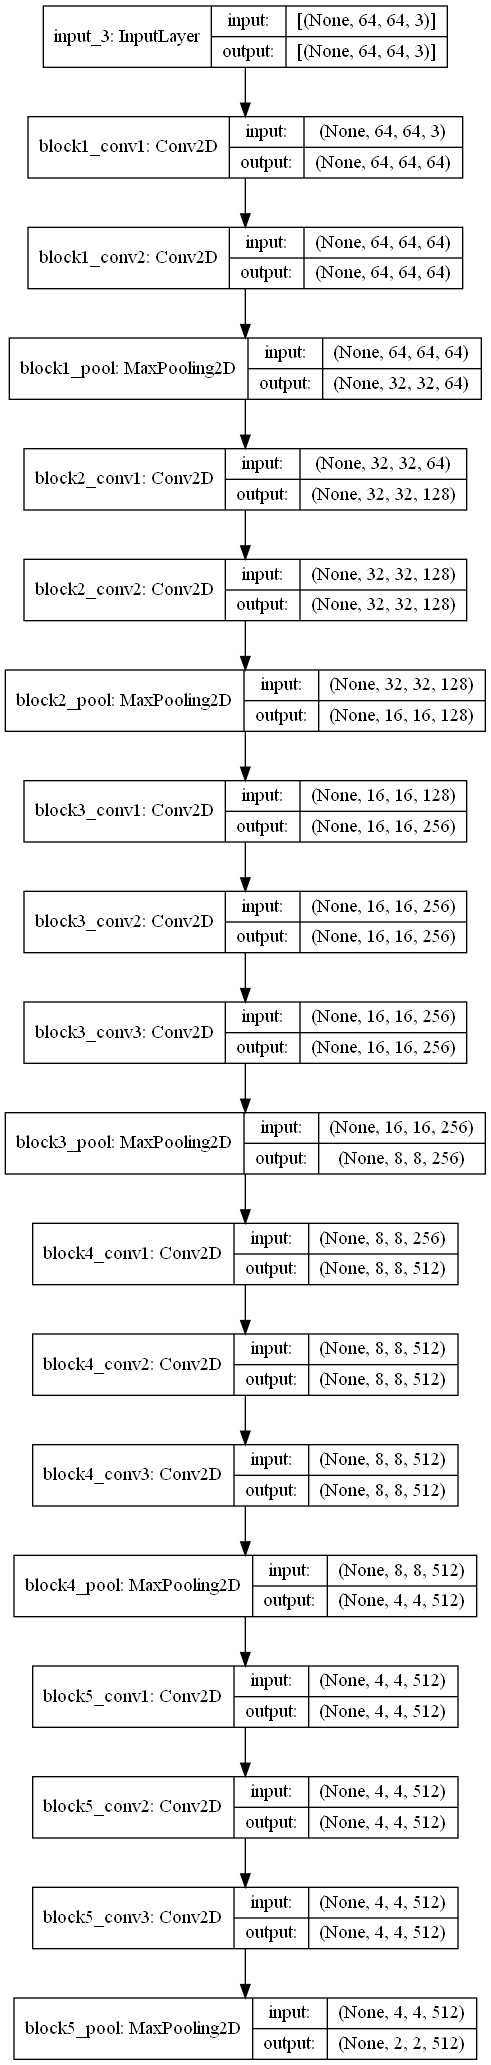

Train Feature Shape: (19200, 2048)
Val Feature Shape: (4800, 2048)


High Level Model: vgg16  Classifier: rf  Accuracy: 0.8145833333333333

 Confusion Matrix: 

[[533   2   2  16   0  21  10   1  15]
 [  0 562  10   0   0  24   0   1   3]
 [  3  17 498  18   1  18  22  14   9]
 [ 39   0  12 307  25   4  35  12  66]
 [  6   0   2   1 457   0  16  16   2]
 [  8  26  17   5   0 311  15   2  16]
 [ 17   1  44  26  28  13 344  10  17]
 [  0   0  15   0  12   1  12 560   0]
 [ 33   1  10  53   6  41   9   9 338]]


High Level Model: vgg16  Classifier: adb  Accuracy: 0.4897916666666667

 Confusion Matrix: 

[[352  21  16 114  29  17   7   3  41]
 [  2 581   4   0   0  11   0   1   1]
 [  5  81 277   8  89  38   9  86   7]
 [171   1  39 102  97   5  23  15  47]
 [  4   0   3   6 468   1   6   9   3]
 [ 36 167  37   6   1  97  18  10  28]
 [ 60   3  53  35 208  10  86  16  29]
 [  6   6 110   2 143  11  25 284  13]
 [177  22  25  40  59  27  29  17 104]]


High Level Model: vgg16  Classifier: e

Classifier  Accuracy
0         rf  0.814583
1        adb  0.489792
2      etree  0.813750
3        gnb  0.544792
4      dtree  0.643958
5         lr  0.858333
6        sgd  0.861042

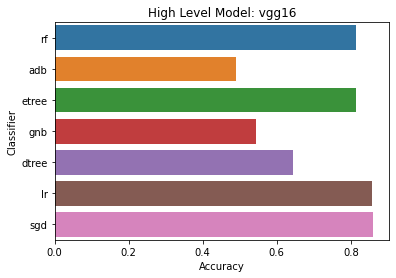

14022

In [22]:
#Get The high Level model object
vgg16_obj = HIGH_LEVEL_MODEL("vgg16")

# Pass the output from high level trained model to each classifier 
# and get the predicted class

for item in CLASSIFIER_LIST:
  execute_classifier_model(item,vgg16_obj)

#Display the result
plot_result("vgg16")
gc.collect()


# **VGG19**

---



Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

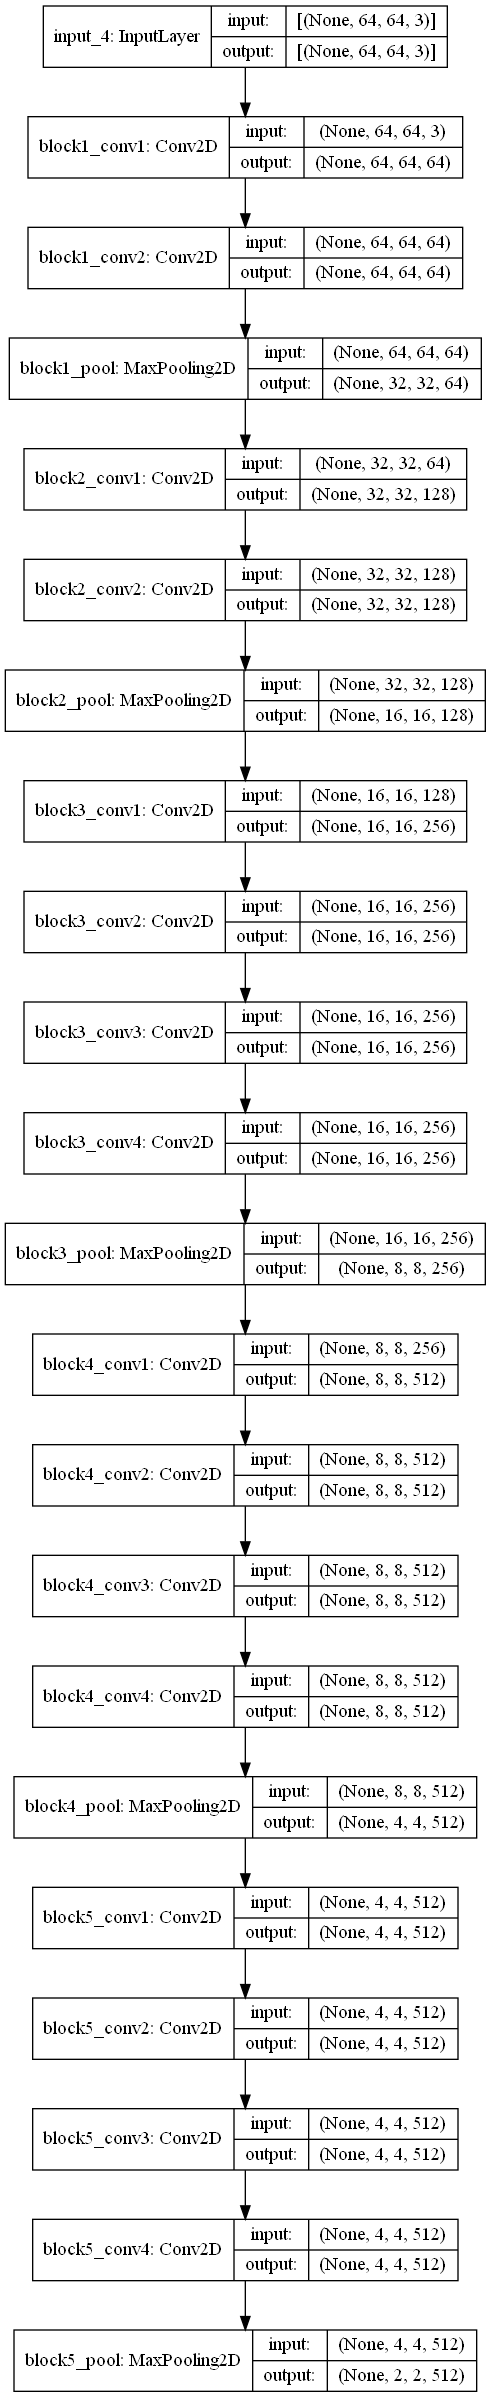

Train Feature Shape: (19200, 2048)
Val Feature Shape: (4800, 2048)


High Level Model: vgg19  Classifier: rf  Accuracy: 0.7814583333333334

 Confusion Matrix: 

[[528   2   3  16   0  19   8   1  23]
 [  5 554   9   0   0  31   0   0   1]
 [  2  20 466  19   5  32  28  22   6]
 [ 36   0   9 310  17   7  41  10  70]
 [  6   0   1  16 439   0  13  25   0]
 [ 13  24  30   6   0 287  13   6  21]
 [ 18   0  44  39  29   8 312  18  32]
 [  0   0  17   6  14   2  14 546   1]
 [ 44   2  17  54   7  51  10   6 309]]


High Level Model: vgg19  Classifier: adb  Accuracy: 0.4664583333333333

 Confusion Matrix: 

[[486  18   1   9   8  26   5   2  45]
 [  7 584   0   0   0   9   0   0   0]
 [ 21 133  69   7 110 161  29  62   8]
 [183   5   7  33 135  18  29   6  84]
 [ 10   0   0   1 478   0   2   2   7]
 [ 45 135  11   9   4 147  11  25  13]
 [ 75   4  14  21 237  23  74  17  35]
 [  8   4  25   3 225  53  24 253   5]
 [183  30   6  40  32  61  20  13 115]]


High Level Model: vgg19  Classifier: e

Classifier  Accuracy
0         rf  0.781458
1        adb  0.466458
2      etree  0.779167
3        gnb  0.505833
4      dtree  0.611042
5         lr  0.819167
6        sgd  0.826667

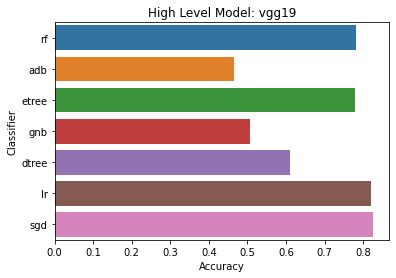

7618

In [23]:
#Get The high Level model object
vgg19_obj = HIGH_LEVEL_MODEL("vgg19")

# Pass the output from high level trained model to each classifier 
# and get the predicted class
for item in CLASSIFIER_LIST:
  execute_classifier_model(item,vgg19_obj)

#Display the result
plot_result("vgg19")
gc.collect()


# **ResNet50**

---



Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

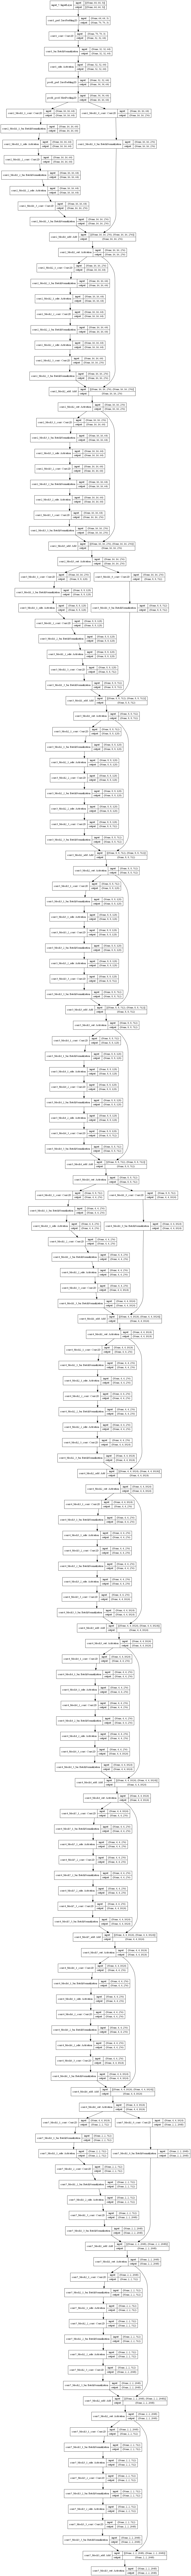

Train Feature Shape: (19200, 8192)
Val Feature Shape: (4800, 8192)


High Level Model: resnet50  Classifier: rf  Accuracy: 0.6020833333333333

 Confusion Matrix: 

[[380   6  43  28  14  46  33  11  39]
 [  0 550  21   0   0  27   1   0   1]
 [ 17  27 319  26  31  48  44  67  21]
 [ 83   0  28 204  25  21  47  41  51]
 [  2   0   0   9 441   0  17  31   0]
 [ 23  37  76  13   0 209   7   4  31]
 [ 48   1  70  53  38  21 164  83  22]
 [  0   0  49   9  26   0  20 494   2]
 [ 81   8  54  80  11  70  44  23 129]]


High Level Model: resnet50  Classifier: adb  Accuracy: 0.36791666666666667

 Confusion Matrix: 

[[115  66 239  52  77   4  13  17  17]
 [  0 557  41   0   0   0   0   2   0]
 [ 14 108 300  12  94  10   4  55   3]
 [ 54  37 138 103 120   5   5  22  16]
 [  0   0   0   1 497   0   1   1   0]
 [  7 182 186   2   2   6   1  12   2]
 [ 41  22 136  58 164   4   9  52  14]
 [  7   5  31   5 362  16   6 156  12]
 [ 46  62 223  57  58   5   6  20  23]]


High Level Model: resnet50  Cla

Classifier  Accuracy
0         rf  0.602083
1        adb  0.367917
2      etree  0.573750
3        gnb  0.297083
4      dtree  0.458958
5         lr  0.539167
6        sgd  0.496667

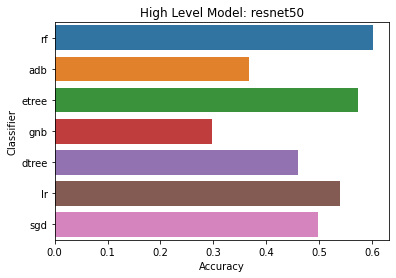

5699

In [24]:
#Get The high Level model object
resnet50_obj = HIGH_LEVEL_MODEL("resnet50")
# Pass the output from high level trained model to each classifier 
# and get the predicted class

for item in CLASSIFIER_LIST:
  execute_classifier_model(item,resnet50_obj)

#Display the result
plot_result("resnet50")
gc.collect()

# **DenseNet121**

---



29089792/29084464 [==============================] - 5s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
_______________________

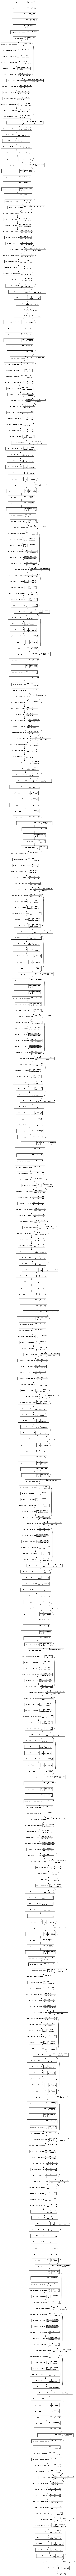

Train Feature Shape: (19200, 4096)
Val Feature Shape: (4800, 4096)


High Level Model: densenet121  Classifier: rf  Accuracy: 0.8360416666666667

 Confusion Matrix: 

[[534   2  11  10   1  15  11   1  15]
 [  2 557  29   1   0  10   0   1   0]
 [  0  19 533   9   0   6  19  11   3]
 [ 39   1   8 343  13  11  25   9  51]
 [  2   0   0   4 452   0   4  33   5]
 [  8  29  21  18   1 302  11   1   9]
 [ 28   0  54  25  16   2 355  14   6]
 [  0   1  11   3  17   2   9 554   3]
 [ 23   1  10  39   6  22  11   5 383]]


High Level Model: densenet121  Classifier: adb  Accuracy: 0.623125

 Confusion Matrix: 

[[411  10  10  26   6  36  61   1  39]
 [  2 576   7   0   0  13   0   1   1]
 [  6  55 389   9   4  24  75  29   9]
 [ 72   1  20 142  60  45  73  18  69]
 [  2   0   3  10 437   0  11  35   2]
 [ 29  67  31  18   0 211  23   3  18]
 [ 88   1  58  52  34  36 177  34  20]
 [  3   4  45   9  31   3  29 473   3]
 [110   1  14  74  35  42  39  10 175]]


High Level Model: densenet121  Class

Classifier  Accuracy
0         rf  0.836042
1        adb  0.623125
2      etree  0.818542
3        gnb  0.683958
4      dtree  0.620000
5         lr  0.887708
6        sgd  0.870625

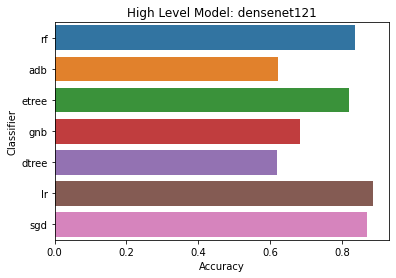

127340

In [25]:
#Get The high Level model object
densenet121_obj = HIGH_LEVEL_MODEL("densenet121")
# Pass the output from high level trained model to each classifier 
# and get the predicted class

for item in CLASSIFIER_LIST:
  execute_classifier_model(item,densenet121_obj)

#Display the result
plot_result("densenet121")
gc.collect()


# **DenseNet169**

---



51879936/51877672 [==============================] - 10s 0us/step
Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 70, 70, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________

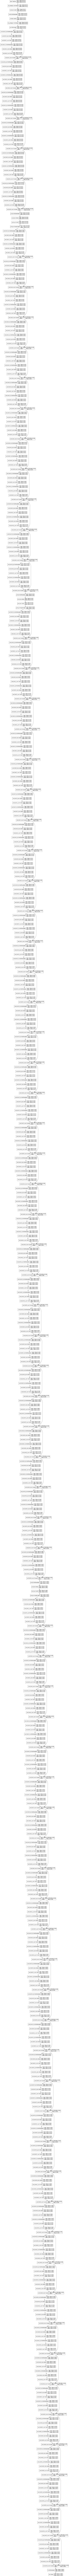

Train Feature Shape: (19200, 6656)
Val Feature Shape: (4800, 6656)


High Level Model: densenet169  Classifier: rf  Accuracy: 0.8452083333333333

 Confusion Matrix: 

[[537   3  11  11   1  11  11   1  14]
 [  0 567  22   0   0   9   0   2   0]
 [  1  18 543   6   0   5  11  10   6]
 [ 39   1   6 360   9  16  15  11  43]
 [  3   0   1   8 444   0   6  33   5]
 [ 10  26  19   7   0 311  13   4  10]
 [ 42   0  39  17  16   3 363  19   1]
 [  0   0   3   6  24   0   4 560   3]
 [ 22   3  10  45   9  21   9   9 372]]


High Level Model: densenet169  Classifier: adb  Accuracy: 0.40125

 Confusion Matrix: 

[[ 98   5  21   8 389  21  13  22  23]
 [  1 580  14   0   0   5   0   0   0]
 [  5 105 263  13  66  49   8  80  11]
 [ 28   1  18  56 298  25  16  46  12]
 [ 14   0   2   3 446   1   2  32   0]
 [ 11  47  59  18  63 135   1  59   7]
 [ 13   2  21   6 341  14   9  93   1]
 [ 21   4  76  13 121  53   8 296   8]
 [ 43   3  23  40 292  18  13  25  43]]


High Level Model: densenet169  Classi

Classifier  Accuracy
0         rf  0.845208
1        adb  0.401250
2      etree  0.831667
3        gnb  0.672292
4      dtree  0.610417
5         lr  0.880625
6        sgd  0.875208

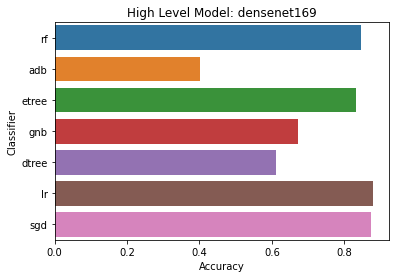

7367

In [26]:
#Get The high Level model object
densenet169_obj = HIGH_LEVEL_MODEL("densenet169")
# Pass the output from high level trained model to each classifier 
# and get the predicted class
for item in CLASSIFIER_LIST:
  execute_classifier_model(item,densenet169_obj)

#Display the result
plot_result("densenet169")
gc.collect()

# **Summary of Experimentation**

Combine result of all high level model for each of the classifier


---



Model Classifier  Accuracy
0         vgg16         rf  0.814583
1         vgg16        adb  0.489792
2         vgg16      etree  0.813750
3         vgg16        gnb  0.544792
4         vgg16      dtree  0.643958
5         vgg16         lr  0.858333
6         vgg16        sgd  0.861042
7         vgg19         rf  0.781458
8         vgg19        adb  0.466458
9         vgg19      etree  0.779167
10        vgg19        gnb  0.505833
11        vgg19      dtree  0.611042
12        vgg19         lr  0.819167
13        vgg19        sgd  0.826667
14     resnet50         rf  0.602083
15     resnet50        adb  0.367917
16     resnet50      etree  0.573750
17     resnet50        gnb  0.297083
18     resnet50      dtree  0.458958
19     resnet50         lr  0.539167
20     resnet50        sgd  0.496667
21  densenet121         rf  0.836042
22  densenet121        adb  0.623125
23  densenet121      etree  0.818542
24  densenet121        gnb  0.683958
25  densenet121      dtree  0.620000
26  densenet121         lr  0.887708
27  densenet121        sgd  0.870625
28  densenet169         rf  0.845208
29  densenet169        adb  0.401250
30  densenet169      etree  0.831667
31  densenet169        gnb  0.672292
32  densenet169      dtree  0.610417
33  densenet169         lr  0.880625
34  densenet169        sgd  0.875208





Maximum Accuracy:           Model Classifier  Accuracy
26  densenet121         lr  0.887708


<Figure size 432x288 with 0 Axes>

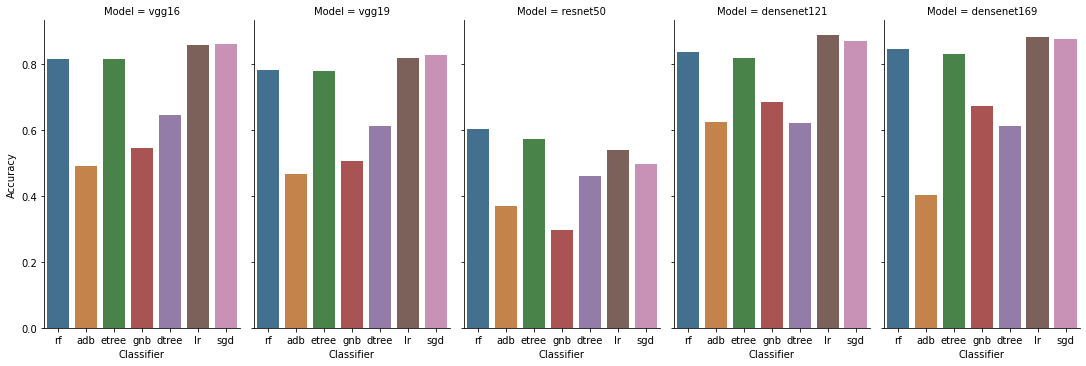

In [27]:
display_combine_result()

###  Highest Validation Accuracy value is 0.8877 from densenet121 with Logistic Regression

---

